In [1]:
import numpy as np
import pandas as pd
import os

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from scipy.special import rel_entr
from scipy.stats import entropy
import scipy.stats
import math
import warnings 
warnings.filterwarnings("ignore") 

In [2]:
# 使用GPU
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
! nvidia-smi

Sun May 15 19:13:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 36%   46C    P8    40W / 260W |     22MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 31%   

# MongoDB

In [4]:
from pymongo import MongoClient
import pymongo

In [5]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    db_de = db.patent_de
    db_us = db.patent_us
    db_cn = db.patent_cn
    db_rm_cn_5 = db.rm_patent_cn_5
    db_rm_cn_10 = db.rm_patent_cn_10
    db_rm_us_5 = db.rm_patent_us_5
    db_rm_us_10 = db.rm_patent_us_10
    db_rm_de_5 = db.rm_patent_de_5
    db_rm_de_10 = db.rm_patent_de_10
    
except errors.ConnectionFailure as err:
    print(err)

# 前五年

## Company數量

In [6]:
data_assignee = db_rm_de_10.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])

In [7]:
df_family_de = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [8]:
data_assignee = db_rm_cn_10.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])
    
df_family_cn = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [9]:
data_assignee = db_rm_us_10.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])
    
df_family_us = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [10]:
final_df = pd.concat([df_family_de,df_family_cn,df_family_us],axis=0)

In [11]:
# 取總數前15家公司
final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)

,company,count
48,Qualcomm Inc,5147
51,Samsung Electronics Co Ltd,3921
31,Intel Corp,2043
27,Huawei Technologies Co Ltd,1861
66,Telefonaktiebolaget LM Ericsson AB,1629
33,International Business Machines Corp,1484
36,LG Electronics Inc,1484
14,Cisco Technology Inc,819
4,Apple Inc,775
39,Microsoft Technology Licensing LLC,656


In [12]:
com_df = final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)

In [13]:
com_df.reset_index(drop=True, inplace=True)

In [14]:
# com_ls = list(final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)["company"])
# com_ls

['Qualcomm Inc',
 'Samsung Electronics Co Ltd',
 'Intel Corp',
 'Telefonaktiebolaget LM Ericsson AB',
 'Huawei Technologies Co Ltd',
 'LG Electronics Inc',
 'International Business Machines Corp',
 'Apple Inc',
 'Cisco Technology Inc',
 'Microsoft Technology Licensing LLC',
 'Micron Technology Inc',
 'Sony Corp',
 'Nokia Technologies Oy',
 'Shenzhen Shenglu IoT Communication Technology Co Ltd',
 'NTT Docomo Inc']

In [15]:
# com_ls=['Qualcomm Inc', 'Samsung Electronics Co Ltd', 'Intel Corp', 'Telefonaktiebolaget LM Ericsson AB', 'Huawei Technologies Co Ltd', 'LG Electronics Inc', 'International Business Machines Corp', 'Apple Inc', 'Cisco Technology Inc', 'Microsoft Technology Licensing LLC', 'Micron Technology Inc', 'Sony Corp', 'Nokia Technologies Oy', 'Shenzhen Shenglu IoT Communication Technology Co Ltd', 'NTT Docomo Inc']

In [16]:
# com_count = [8491,6337,3236,2488,2461,1931,1591,1104,1092,963,731,711,668,656,612]

In [17]:
# com_df = pd.DataFrame((zip(com_ls, com_count)), columns = ['company', 'count'])

In [18]:
com_df["count_log"] = com_df["count"].apply(lambda x: np.log(x))

In [19]:
com_df

,company,count,count_log
0,Qualcomm Inc,5147,8.546169
1,Samsung Electronics Co Ltd,3921,8.274102
2,Intel Corp,2043,7.622175
3,Huawei Technologies Co Ltd,1861,7.528869
4,Telefonaktiebolaget LM Ericsson AB,1629,7.395722
5,International Business Machines Corp,1484,7.302496
6,LG Electronics Inc,1484,7.302496
7,Cisco Technology Inc,819,6.708084
8,Apple Inc,775,6.652863
9,Microsoft Technology Licensing LLC,656,6.486161


In [20]:
com_ls = list(com_df.company)

## Data

In [21]:
ccontry = pd.read_csv("./final_data/rm_company_country_all_10.csv")

In [22]:
ccpc = pd.read_csv("./final_data/rm_company_cpc_all_10.csv")

In [23]:
ccontry[ccontry.company.isin(com_ls)].head()

,company,AP,AR,AT,AU,BE,BG,BR,CA,CH,...,SE,SG,SI,TN,TR,TW,US,UY,WO,ZA
549,Apple Inc,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,20.0,688.0,0.0,704.0,0.0
2407,Cisco Technology Inc,0.0,0.0,0.0,7.0,0.0,0.0,0.0,20.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,826.0,0.0,170.0,0.0
5321,Huawei Technologies Co Ltd,0.0,2.0,0.0,52.0,0.0,0.0,149.0,55.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,804.0,0.0,1559.0,4.0
5804,Intel Corp,0.0,0.0,0.0,4.0,0.0,0.0,20.0,1.0,0.0,...,0.0,8.0,0.0,0.0,0.0,57.0,2067.0,0.0,878.0,0.0
5839,International Business Machines Corp,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1519.0,0.0,97.0,2.0


## Similarity計算

### Country

- 換成機率  

In [24]:
ccontry.set_index("company", inplace=True)
ccontry2 = ccontry.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

In [25]:
P = ccontry2[ccontry2.index==com_ls[0]].values.tolist()[0][1:]
Q = ccontry2[ccontry2.index==com_ls[1]].values.tolist()[0][1:]

In [26]:
# print(P)
# print(Q)

### PBC
- 和Samsung Electronics Co Ltd比較

In [27]:
ccontry_pbc = ccontry2.loc[com_ls,:].copy()
ccontry_pbc

,AP,AR,AT,AU,BE,BG,BR,CA,CH,CL,...,SE,SG,SI,TN,TR,TW,US,UY,WO,ZA
company,,,,,,,,,,,,,,,,,,,,,
Qualcomm Inc,0.000000,0.000391,0.0,0.015795,0.0,0.0,0.036677,0.014622,0.0,0.001418,...,0.0,0.025820,0.000293,0.000196,0.000000,0.065089,0.247738,0.0,0.227933,0.000391
Samsung Electronics Co Ltd,0.000000,0.000000,0.0,0.005317,0.0,0.0,0.000350,0.001539,0.0,0.000000,...,0.0,0.002448,0.000000,0.000000,0.000000,0.007345,0.271843,0.0,0.152291,0.000000
Intel Corp,0.000000,0.000000,0.0,0.000805,0.0,0.0,0.004023,0.000201,0.0,0.000000,...,0.0,0.001609,0.000000,0.000000,0.000000,0.011467,0.415812,0.0,0.176624,0.000000
Huawei Technologies Co Ltd,0.000000,0.000358,0.0,0.009306,0.0,0.0,0.026664,0.009843,0.0,0.000000,...,0.0,0.000358,0.000000,0.000000,0.000000,0.000000,0.143880,0.0,0.278991,0.000716
Telefonaktiebolaget LM Ericsson AB,0.000137,0.015290,0.0,0.010512,0.0,0.0,0.027031,0.010375,0.0,0.001502,...,0.0,0.002730,0.000000,0.000000,0.000546,0.004915,0.205870,0.0,0.217611,0.009010
International Business Machines Corp,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000544,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.825992,0.0,0.052746,0.001088
LG Electronics Inc,0.000000,0.000246,0.0,0.004179,0.0,0.0,0.004425,0.001721,0.0,0.001967,...,0.0,0.002704,0.000000,0.000000,0.000000,0.001967,0.350295,0.0,0.227384,0.000246
Cisco Technology Inc,0.000000,0.000000,0.0,0.005804,0.0,0.0,0.000000,0.016584,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.684909,0.0,0.140962,0.000000
Apple Inc,0.000000,0.000000,0.0,0.001600,0.0,0.0,0.000400,0.000000,0.0,0.000000,...,0.0,0.000400,0.000000,0.000000,0.000000,0.008000,0.275200,0.0,0.281600,0.000000


In [28]:
def PBC(a,b):
    return sum(a*b)

ccontry_pbc["sum"] = ccontry_pbc.apply(lambda x: PBC(ccontry_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

###### n

In [29]:
pbc_ls=[]
n=0.05

for i in ccontry_pbc.index:
    pbc = ccontry_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
    pbc_ls.append(pbc[0])
    
ccontry_pbc["pbc"]=pbc_ls

In [30]:
# ccontry_pbc.sort_values(["pbc"],ascending=True)

### CPC

In [31]:
ccpc.set_index("company", inplace=True)
ccpc2 = ccpc.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

In [32]:
ccpc_pbc = ccpc2.loc[com_ls,:].copy()
# ccpc_pbc

In [33]:
def PBC(a,b):
    return sum(a*b)

ccpc_pbc["sum"] = ccpc_pbc.apply(lambda x: PBC(ccpc_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

###### n

In [34]:
pbc_ls=[]
n=0.06

for i in ccpc_pbc.index:
    pbc = ccpc_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
    pbc_ls.append(pbc[0])
    
ccpc_pbc["pbc"]=pbc_ls

In [35]:
ccpc_pbc.sort_values(["pbc"],ascending=True)

,A01,A21,A22,A23,A24,A41,A42,A43,A44,A45,...,H01,H02,H03,H04,H05,Y02,Y04,Y10,sum,pbc
company,,,,,,,,,,,,,,,,,,,,,
International Business Machines Corp,0.001638,0.0,0.0,0.000000,0.000078,0.000078,0.000000,0.000000,0.000000,0.000000,...,0.071685,0.008268,0.002652,0.255538,0.001794,0.010218,0.002106,0.000156,0.236649,0.293290
Samsung Electronics Co Ltd,0.000000,0.0,0.0,0.000043,0.000000,0.000128,0.000021,0.000085,0.000213,0.000745,...,0.059223,0.014497,0.017243,0.519936,0.011836,0.008451,0.000426,0.000170,0.323930,0.323930
Intel Corp,0.000389,0.0,0.0,0.000000,0.000000,0.000146,0.000000,0.000146,0.000000,0.000000,...,0.105368,0.011270,0.013894,0.477046,0.008064,0.013845,0.001020,0.000000,0.319814,0.345314
LG Electronics Inc,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000167,0.000056,0.000000,0.000111,...,0.002613,0.001779,0.004002,0.553252,0.002168,0.007393,0.000389,0.000000,0.321300,0.377941
Xian Irain IoT Technology Service Co Ltd,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.004472,0.000000,0.118068,0.000000,0.024150,0.003578,0.000000,0.142894,0.407050
Qualcomm Inc,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000019,0.000000,...,0.036818,0.000944,0.019233,0.880643,0.002499,0.008663,0.000111,0.000000,0.466287,0.470729
Shenzhen Shenglu IoT Communication Technology Co Ltd,0.004683,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000520,...,0.031738,0.003642,0.000000,0.478668,0.016129,0.034860,0.002081,0.000000,0.282558,0.475018
Microsoft Technology Licensing LLC,0.000162,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000324,...,0.005824,0.006957,0.001618,0.352208,0.000971,0.004530,0.000647,0.000000,0.300868,0.492672
Huawei Technologies Co Ltd,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.005982,0.000738,0.012456,0.902319,0.001147,0.015160,0.000246,0.000000,0.479087,0.512410


## Scatter Plot

In [36]:
# loop test
def scatter_plot(pbc_n,cpc_n):
    # PBC
    pbc_ls=[]
    n = pbc_n
    for i in ccontry_pbc.index:
        pbc = ccontry_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccontry_pbc["pbc"]=pbc_ls
    
    # CPC
    pbc_ls=[]
    n = cpc_n
    for i in ccpc_pbc.index:
        pbc = ccpc_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccpc_pbc["pbc"]=pbc_ls
    
    c_df = pd.DataFrame((zip(list(ccpc_pbc["pbc"]), list(ccontry_pbc["pbc"]))), columns = ['cpc', 'country'])
    c_df.set_index(ccpc_pbc.index, inplace=True)

    return c_df

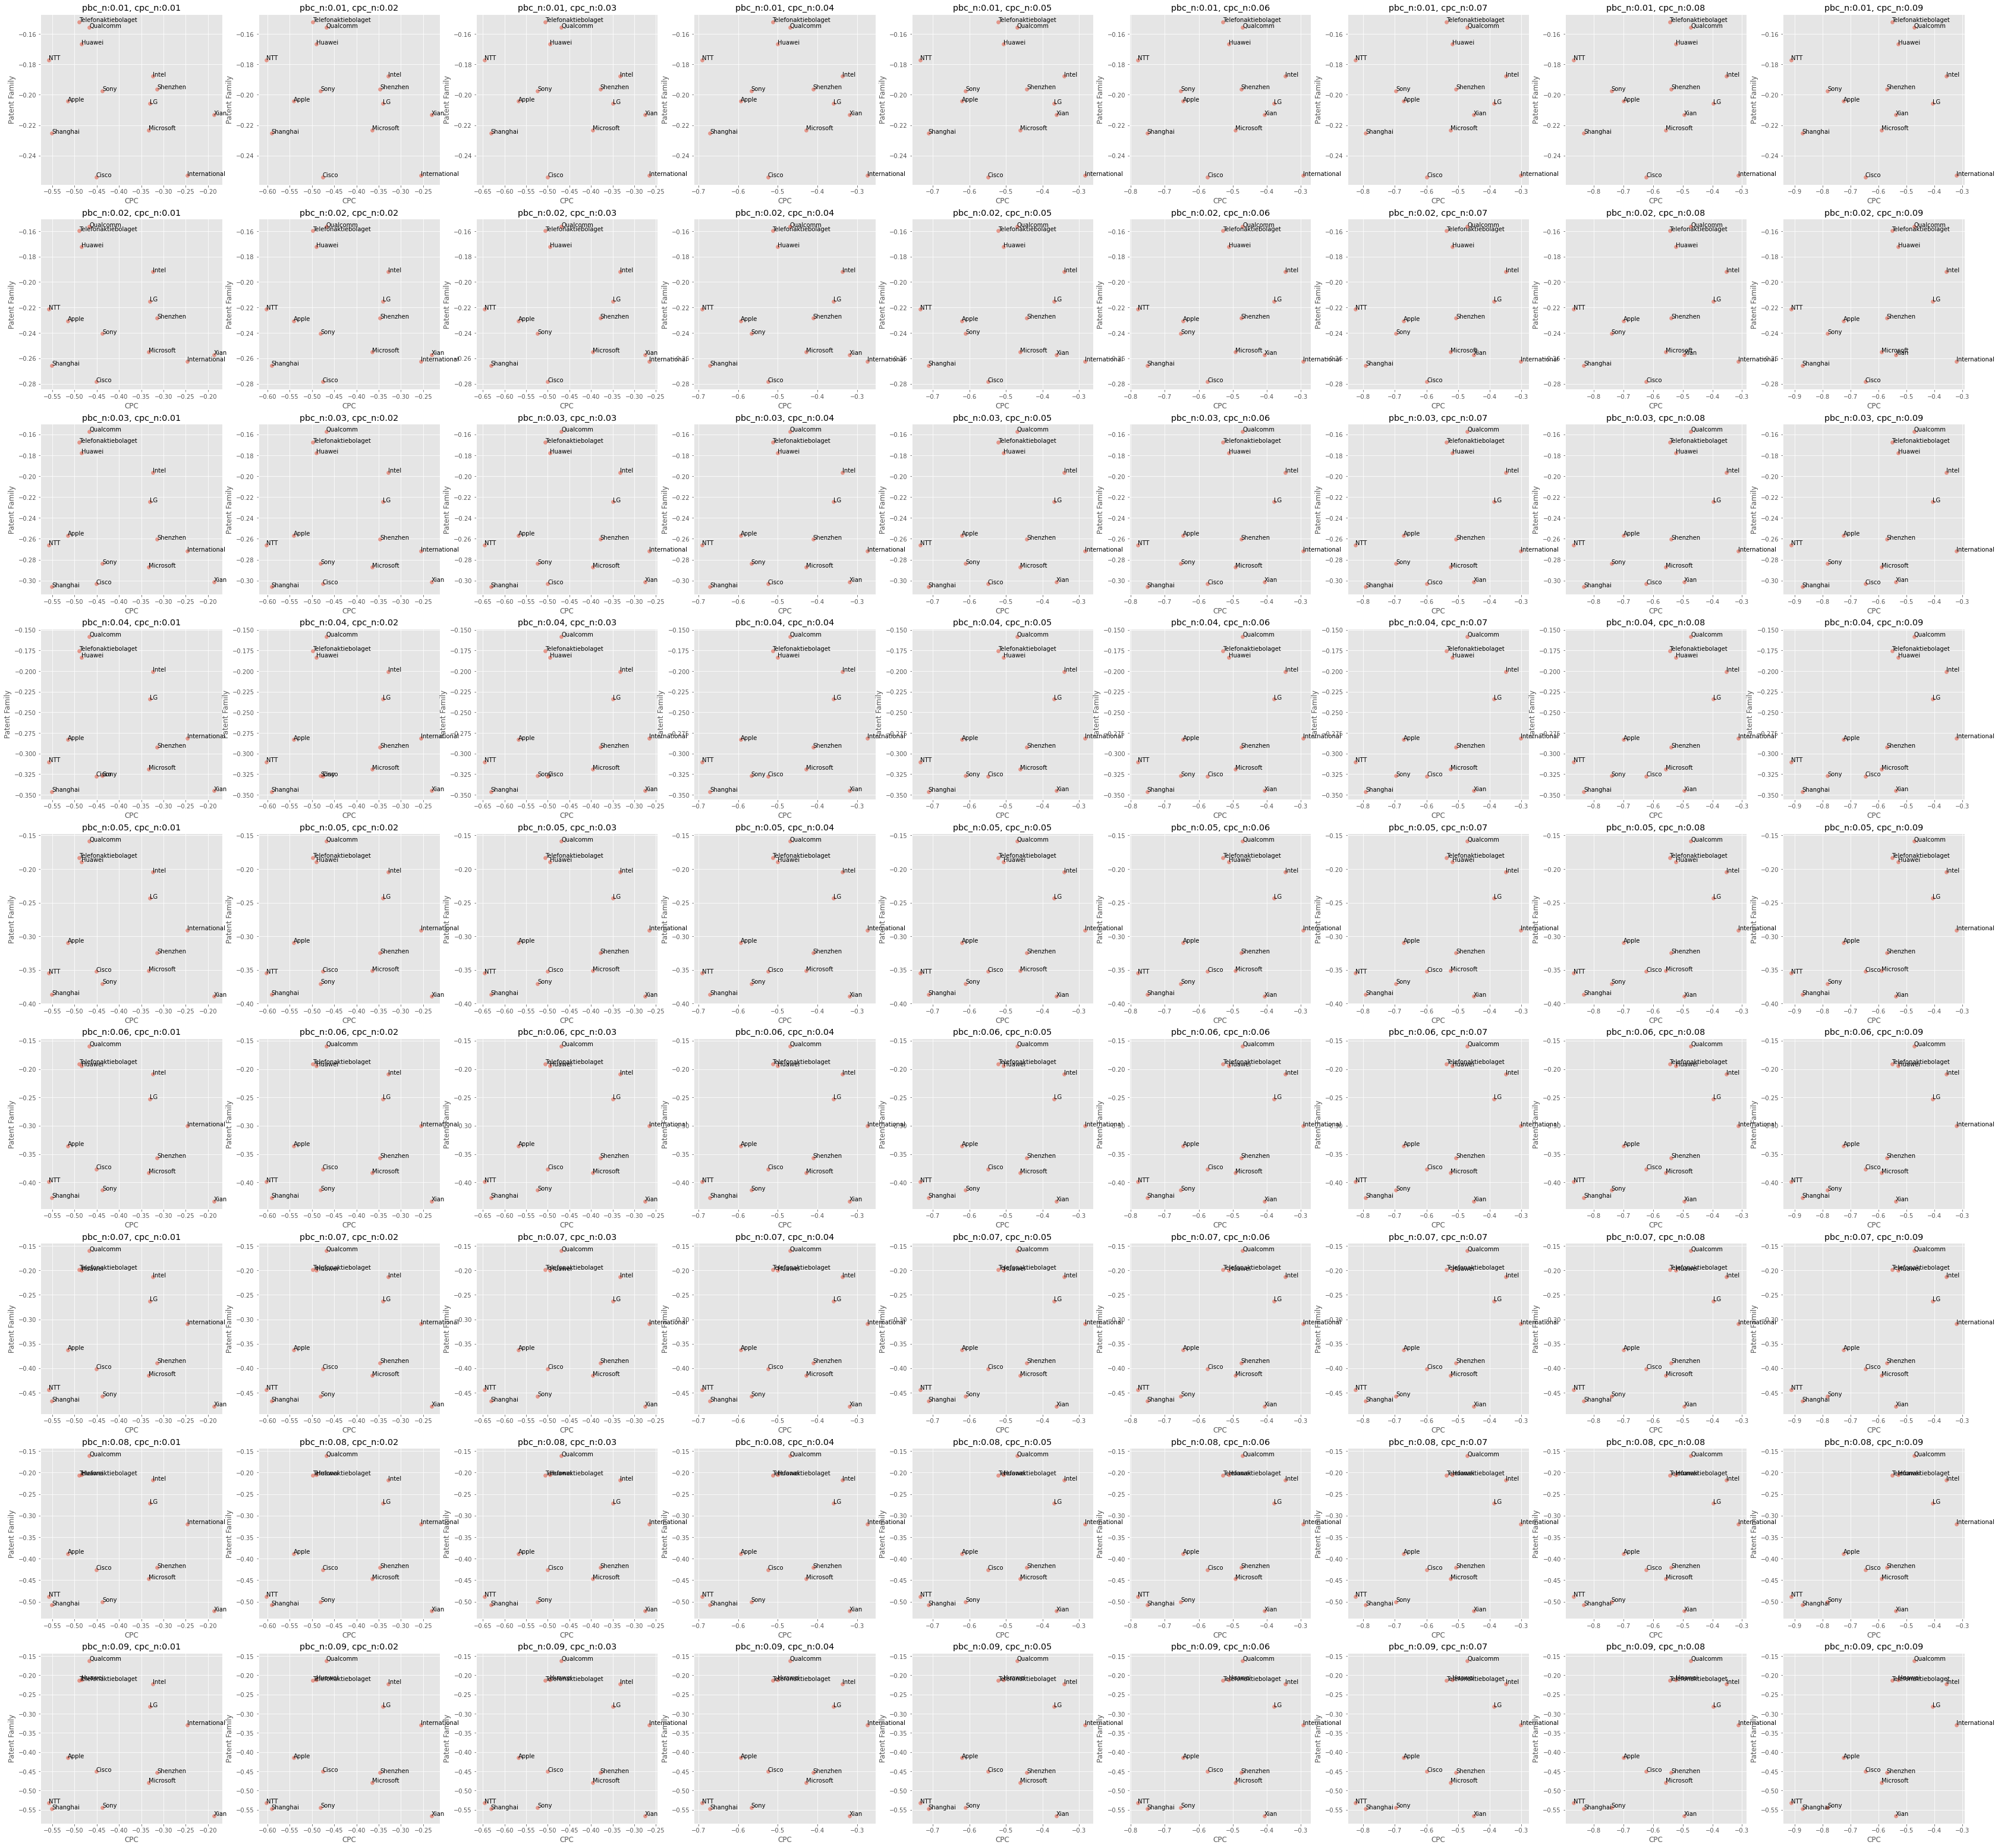

In [39]:
pbc_n_ls=np.arange(0.01,0.1,0.01)
cpc_n_ls=np.arange(0.01,0.1,0.01)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("CPC")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/years/plot_all_10_2.png'.format(pbc_n))

In [40]:
c_df

,cpc,country
company,,
Qualcomm Inc,0.472949,0.161600
Intel Corp,0.358064,0.221764
Huawei Technologies Co Ltd,0.529071,0.211176
Telefonaktiebolaget LM Ericsson AB,0.551960,0.213776
International Business Machines Corp,0.321610,0.328510
LG Electronics Inc,0.406261,0.281200
Cisco Technology Inc,0.647691,0.450215
Apple Inc,0.725366,0.414537
Microsoft Technology Licensing LLC,0.588574,0.478941
